In [1]:
# this is mac mps specific
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

## **Part II: Understanding the User's Journey and Network**

### **Chapter 3: The Session-Aware Recommender: Sequential Models for In-the-Moment Personalization**

#### **3.1 Introduction: Beyond a Single Click - Modeling User Intent**

In the previous chapters, we built and contrasted two powerful but fundamentally different recommendation paradigms. Our batched MLP model learned a static, long-term profile of a user's preferences. Our LinUCB agent learned to adapt to these preferences in real-time, intelligently exploring to maximize rewards over time. Yet, both models share a critical blind spot: they are largely "memoryless" on a moment-to-moment basis. They treat each user interaction as an isolated event, failing to consider the rich context provided by the user's *immediate* actions within the current browsing session.

Consider Anna, our `new_puppy_parent`. Her long-term profile indicates a preference for dog-related products. But what is she trying to accomplish *right now*?
*   **Session A:** She clicks on "Puppy Food," then "Food Bowl," then "Water Dispenser." Her intent is clear: she is setting up the feeding station for her new pet. The next logical recommendation is not a random dog toy, but perhaps "Puppy Training Treats" or a "Placemat for Food Bowls."
*   **Session B:** A few weeks later, she clicks on "Flea & Tick Prevention," then "Dog Shampoo," then "Grooming Brush." Her current mission is pet hygiene. The best recommendation would be "Nail Clippers" or "Medicated Ear Wipes."

Both the static MLP and the contextual bandit would struggle to distinguish between these two sessions. They see a `new_puppy_parent` and recommend a high-average-CTR item like a "Dog Toy," missing the specific, in-the-moment user intent.

This is the limitation we will address in this chapter. We will move beyond single-interaction predictions and build a **session-aware recommender**. Our goal is to model the *sequence* of a user's actions to predict their next move. By understanding the "grammar" of a user's journey, we can achieve a much deeper and more responsive form of personalization.

#### **3.2 The Frontier Technique: Transformer Architectures for Recommendations**

To model sequences, the natural inclination for many years was to turn to Recurrent Neural Networks (RNNs) and their more powerful variants like LSTMs and GRUs. These models process a sequence element by element, maintaining a "hidden state" that acts as a memory of what has been seen so far. While effective, they suffer from two key weaknesses: difficulty in capturing very long-range dependencies and an inherently sequential nature that makes them difficult to parallelize during training.

The modern solution, which has revolutionized natural language processing and is now a frontier technique in recommendations, is the **Transformer architecture**. The power of the Transformer lies in its core mechanism: **self-attention**.

Instead of processing a sequence one item at a time, the self-attention mechanism allows the model to look at the entire sequence at once and, for each item, calculate an "attention score" that determines how important all other items in the sequence are to it. In our Zooplus example, when predicting the item that should follow "Puppy Food" -> "Food Bowl", the self-attention mechanism can learn that "Puppy Food" is a much more important clue than an unrelated item clicked at the beginning of the session.

We will implement a specific, well-regarded Transformer-based model for recommendations: the **Behavioral Sequence Transformer (BST)**. The architecture is an elegant application of the Transformer's encoder block for the task of next-item prediction.

Here's a conceptual overview of the BST model:
1.  **Inputs:** The model takes two primary inputs: a user's recent behavior sequence (e.g., the last 10 products they clicked on) and a "target item" (a candidate product we are considering recommending).
2.  **Embedding:** All items in the behavior sequence and the target item are converted from IDs into dense, learned embedding vectors. This is the same `nn.Embedding` concept from Chapter 1.
3.  **Positional Encoding:** Because the self-attention mechanism itself has no inherent sense of order, we add a "positional embedding" to each item in the sequence. This vector encodes the item's position (e.g., 1st, 2nd, 3rd...), giving the model a crucial sense of temporality.
4.  **Transformer Encoder (Self-Attention):** The sequence of (item + positional) embeddings is fed into a Transformer Encoder layer. This layer performs self-attention, allowing every item to "communicate" with every other item. The output is a new sequence of context-aware embeddings, where each item's representation has been enriched with information from its neighbors.
5.  **Aggregation & Prediction:** The context-aware embeddings from the sequence are aggregated (e.g., averaged or concatenated). This aggregated vector, representing the user's overall session intent, is then combined with the target item's embedding.
6.  **MLP Tower:** This final combined vector is passed through a few dense layers (an MLP) to produce a final prediction: the probability that the user will click on the target item, given their behavior sequence.

Let's begin by preparing our data for this new, sequence-aware model.

### **3.3 Building a Behavioral Sequence Transformer (BST) for Zooplus**

#### **Step 1: Preparing Sequential Data - A Detailed Walkthrough**

Before we can build our Transformer model, we must first reshape our data. Our current `interaction_log` is a simple list of events: `(user_id, product_id, clicked)`. A sequential model, however, doesn't learn from isolated events. It learns from *ordered sequences*. Our goal in this section is to convert our flat log into a structured dataset where each sample looks like this:

`(a user's recent history, a candidate item, a label telling us if the user clicked it)`

This process involves several critical data manipulation and feature engineering steps. Let's break down the code you provided, piece by piece, to understand the logic.

```python
# Adjust simulator to use 1-based indexing for products.
sim = ZooplusSimulator(n_products=50, seed=42)
sim.products.index = sim.products.index + 1 # Shift index to be 1 to 50

# We only need the interactions of users who actually clicked on something
interaction_log = generate_training_data(sim, 200_000)
interaction_log = interaction_log[interaction_log['clicked'] == 1].drop('clicked', axis=1)

# ... (create_sequences and generate_negative_samples functions) ...
```

#### **Dissection 1: The Importance of Padding and 1-Based Indexing**

```python
# Adjust simulator to use 1-based indexing for products.
sim = ZooplusSimulator(n_products=50, seed=42)
sim.products.index = sim.products.index + 1 # Shift index to be 1 to 50
```

**Why do we do this?**

Our Transformer model will require that every input sequence has the exact same length (e.g., `MAX_SEQ_LEN = 10`). However, real user sessions are variable. A user might click on 2 items, while another clicks on 15. To handle this, we use a technique called **padding**.

If a user's history is `[product_45, product_12]`, and our model expects a sequence of length 10, we will "pad" the history to the left with a special token:

`[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, product_45, product_12]`

The model needs to know that `<PAD>` is not a real product and should be ignored. The easiest way to create this special token is to reserve the integer `0` for it. By shifting all our real product IDs to start from `1` (`1` to `50`), we free up `0` to be our unique, unambiguous padding value. This is a standard and essential practice when working with sequences in deep learning.

#### **Dissection 2: Focusing on Positive Interactions**

```python
# We only need the interactions of users who actually clicked on something
interaction_log = generate_training_data(sim, 200_000)
interaction_log = interaction_log[interaction_log['clicked'] == 1].drop('clicked', axis=1)
```
**Why do we filter for `clicked == 1`?**

Our goal is to model a user's *intent*. A user's intent is most clearly expressed by the items they actively choose to engage with (i.e., click on). The sequence of items they *ignored* is much less informative and far noisier. By building our historical sequences only from clicked items, we are training the model on the strongest signal of user interest. We are asking it to learn the "grammar" of a successful user journey.

#### **Dissection 3: The `create_sequences` Function (The Sliding Window)**

This function is the heart of the data transformation. It takes the log of clicks and creates the `(history, target)` pairs.

```python
def create_sequences(df, max_len=10):
    sequences = []
    # Step A: Group by user
    user_groups = df.groupby('user_id')['product_id'].apply(list)

    for user_id, user_interactions in tqdm(user_groups.items(), desc="Creating Sequences"):
        # Step B: Ensure sequence is long enough
        if len(user_interactions) < 2:
            continue
        
        # Step C: The sliding window
        for i in range(1, len(user_interactions)):
            history = user_interactions[max(0, i - max_len):i]
            target = user_interactions[i]
            
            # Step D: Padding
            padded_history = np.pad(history, (max_len - len(history), 0), 'constant', constant_values=0)
            sequences.append((padded_history, target))
    return pd.DataFrame(sequences, columns=['history', 'target_item_id'])
```

*   **Step A: `groupby('user_id')`**: Before we can create a sequence, we must first gather all the actions performed by a single user and put them in order. This gives us an individual timeline for each user.
*   **Step B: `if len < 2`**: A sequence requires at least two items: one for the history and one for the target. A user who only ever clicked one item in total provides no sequential information for us to learn from, so we skip them.
*   **Step C: The Sliding Window `for i in range(...)`**: This is the core logic. Let's visualize it. Imagine a user clicked on items `[p1, p2, p3, p4]`. This loop generates the following training examples:
    1.  `i = 1`: `history = [p1]`, `target = p2`
    2.  `i = 2`: `history = [p1, p2]`, `target = p3`
    3.  `i = 3`: `history = [p1, p2, p3]`, `target = p4`
    This brilliantly multiplies our data, allowing the model to learn from every step of the user's journey. The `max(0, i - max_len)` part ensures we don't try to go back further than the start of the sequence while respecting our maximum length.
*   **Step D: `np.pad`**: Here we apply the padding concept discussed earlier. The arguments `(max_len - len(history), 0)` tell NumPy to add padding *only to the left* of our history array, and `constant_values=0` specifies that our `<PAD>` token is the integer `0`.

#### **Dissection 4: The `generate_negative_samples` Function (The Most Important Step)**

After `create_sequences`, our `seq_data` DataFrame contains thousands of `(history, target)` pairs. These are all **positive examples**—the `target` is always an item the user actually clicked.

**Why is this a problem?** If we only train the model on positive examples, it will learn a useless strategy: "No matter the history or target item, always predict a click probability of 1.0." It has never seen an example of a "bad" recommendation, so it has no incentive to learn to distinguish good from bad.

To solve this, we must create **negative samples**.

```python
def generate_negative_samples(df, n_products):
    # Step A: Copy the positive examples' histories
    neg_df = df.copy()
    
    # Step B: Create random targets
    random_negatives = np.random.randint(1, n_products + 1, size=len(df))
    neg_df['target_item_id'] = random_negatives
    
    # Step C: Assign labels
    df['label'] = 1
    neg_df['label'] = 0
    
    # Step D: Combine and shuffle
    return pd.concat([df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)
```

*   **Step A & B**: For each *real* sequence `(history -> good_target)`, we create a corresponding *fake* sequence `(history -> bad_target)`. We do this by keeping the `history` the same but replacing the `good_target` with a `bad_target` chosen randomly from the entire product catalog. The assumption is that a random item is highly unlikely to be the specific item the user wanted next.
*   **Step C**: We label the real examples with `1` (positive) and the fake examples with `0` (negative). Now the model has a clear task: learn to output a high score for the positive pairs and a low score for the negative pairs.
*   **Step D**: We combine the positive and negative sets and shuffle them thoroughly. Shuffling is critical to ensure that when we train in mini-batches, each batch contains a mix of positive and negative examples, preventing the model from getting biased during training.

> **A Deeper Dive: Is Random Negative Sampling Perfect?**
>
> No, it's a simple and effective starting point. A known issue is the "false negative" problem: what if we randomly sample a product that the user *would have* clicked? We are incorrectly teaching the model that this was a bad recommendation. More advanced techniques exist, such as "in-batch negative sampling" or sampling based on item popularity (unpopular items are safer bets for being true negatives), but random sampling provides a very strong baseline.

After this final step, we have a clean, structured, and balanced dataset ready to be fed into our Behavioral Sequence Transformer. Each row contains a fixed-length, padded history, a target item, and a label, giving our model everything it needs to learn the subtle art of in-session personalization.

Let's now proceed with building and training the model on this well-prepared data.Of course. This is an excellent point and is crucial for making the material truly educational. Providing the "why" behind the code is just as important as the code itself.

Let's go back and replace the initial data preparation section with a much more detailed, explanatory version that walks through the reasoning for each step.

***

### **3.3 Building a Behavioral Sequence Transformer (BST) for Zooplus**

#### **Step 1: Preparing Sequential Data - A Detailed Walkthrough**

Before we can build our Transformer model, we must first reshape our data. Our current `interaction_log` is a simple list of events: `(user_id, product_id, clicked)`. A sequential model, however, doesn't learn from isolated events. It learns from *ordered sequences*. Our goal in this section is to convert our flat log into a structured dataset where each sample looks like this:

`(a user's recent history, a candidate item, a label telling us if the user clicked it)`

This process involves several critical data manipulation and feature engineering steps. Let's break down the code you provided, piece by piece, to understand the logic.

```python
# The code block from the prompt is reproduced here for context.
# ... (imports and Simulator class definition) ...

# Adjust simulator to use 1-based indexing for products.
sim = ZooplusSimulator(n_products=50, seed=42)
sim.products.index = sim.products.index + 1 # Shift index to be 1 to 50

# We only need the interactions of users who actually clicked on something
interaction_log = generate_training_data(sim, 200_000)
interaction_log = interaction_log[interaction_log['clicked'] == 1].drop('clicked', axis=1)

# ... (create_sequences and generate_negative_samples functions) ...
```

#### **Dissection 1: The Importance of Padding and 1-Based Indexing**

```python
# Adjust simulator to use 1-based indexing for products.
sim = ZooplusSimulator(n_products=50, seed=42)
sim.products.index = sim.products.index + 1 # Shift index to be 1 to 50
```

**Why do we do this?**

Our Transformer model will require that every input sequence has the exact same length (e.g., `MAX_SEQ_LEN = 10`). However, real user sessions are variable. A user might click on 2 items, while another clicks on 15. To handle this, we use a technique called **padding**.

If a user's history is `[product_45, product_12]`, and our model expects a sequence of length 10, we will "pad" the history to the left with a special token:

`[<PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, product_45, product_12]`

The model needs to know that `<PAD>` is not a real product and should be ignored. The easiest way to create this special token is to reserve the integer `0` for it. By shifting all our real product IDs to start from `1` (`1` to `50`), we free up `0` to be our unique, unambiguous padding value. This is a standard and essential practice when working with sequences in deep learning.

#### **Dissection 2: Focusing on Positive Interactions**

```python
# We only need the interactions of users who actually clicked on something
interaction_log = generate_training_data(sim, 200_000)
interaction_log = interaction_log[interaction_log['clicked'] == 1].drop('clicked', axis=1)
```
**Why do we filter for `clicked == 1`?**

Our goal is to model a user's *intent*. A user's intent is most clearly expressed by the items they actively choose to engage with (i.e., click on). The sequence of items they *ignored* is much less informative and far noisier. By building our historical sequences only from clicked items, we are training the model on the strongest signal of user interest. We are asking it to learn the "grammar" of a successful user journey.

#### **Dissection 3: The `create_sequences` Function (The Sliding Window)**

This function is the heart of the data transformation. It takes the log of clicks and creates the `(history, target)` pairs.

```python
def create_sequences(df, max_len=10):
    sequences = []
    # Step A: Group by user
    user_groups = df.groupby('user_id')['product_id'].apply(list)

    for user_id, user_interactions in tqdm(user_groups.items(), desc="Creating Sequences"):
        # Step B: Ensure sequence is long enough
        if len(user_interactions) < 2:
            continue
        
        # Step C: The sliding window
        for i in range(1, len(user_interactions)):
            history = user_interactions[max(0, i - max_len):i]
            target = user_interactions[i]
            
            # Step D: Padding
            padded_history = np.pad(history, (max_len - len(history), 0), 'constant', constant_values=0)
            sequences.append((padded_history, target))
    return pd.DataFrame(sequences, columns=['history', 'target_item_id'])
```

*   **Step A: `groupby('user_id')`**: Before we can create a sequence, we must first gather all the actions performed by a single user and put them in order. This gives us an individual timeline for each user.
*   **Step B: `if len < 2`**: A sequence requires at least two items: one for the history and one for the target. A user who only ever clicked one item in total provides no sequential information for us to learn from, so we skip them.
*   **Step C: The Sliding Window `for i in range(...)`**: This is the core logic. Let's visualize it. Imagine a user clicked on items `[p1, p2, p3, p4]`. This loop generates the following training examples:
    1.  `i = 1`: `history = [p1]`, `target = p2`
    2.  `i = 2`: `history = [p1, p2]`, `target = p3`
    3.  `i = 3`: `history = [p1, p2, p3]`, `target = p4`
    This brilliantly multiplies our data, allowing the model to learn from every step of the user's journey. The `max(0, i - max_len)` part ensures we don't try to go back further than the start of the sequence while respecting our maximum length.
*   **Step D: `np.pad`**: Here we apply the padding concept discussed earlier. The arguments `(max_len - len(history), 0)` tell NumPy to add padding *only to the left* of our history array, and `constant_values=0` specifies that our `<PAD>` token is the integer `0`.

#### **Dissection 4: The `generate_negative_samples` Function (The Most Important Step)**

After `create_sequences`, our `seq_data` DataFrame contains thousands of `(history, target)` pairs. These are all **positive examples**—the `target` is always an item the user actually clicked.

**Why is this a problem?** If we only train the model on positive examples, it will learn a useless strategy: "No matter the history or target item, always predict a click probability of 1.0." It has never seen an example of a "bad" recommendation, so it has no incentive to learn to distinguish good from bad.

To solve this, we must create **negative samples**.

```python
def generate_negative_samples(df, n_products):
    # Step A: Copy the positive examples' histories
    neg_df = df.copy()
    
    # Step B: Create random targets
    random_negatives = np.random.randint(1, n_products + 1, size=len(df))
    neg_df['target_item_id'] = random_negatives
    
    # Step C: Assign labels
    df['label'] = 1
    neg_df['label'] = 0
    
    # Step D: Combine and shuffle
    return pd.concat([df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)
```

*   **Step A & B**: For each *real* sequence `(history -> good_target)`, we create a corresponding *fake* sequence `(history -> bad_target)`. We do this by keeping the `history` the same but replacing the `good_target` with a `bad_target` chosen randomly from the entire product catalog. The assumption is that a random item is highly unlikely to be the specific item the user wanted next.
*   **Step C**: We label the real examples with `1` (positive) and the fake examples with `0` (negative). Now the model has a clear task: learn to output a high score for the positive pairs and a low score for the negative pairs.
*   **Step D**: We combine the positive and negative sets and shuffle them thoroughly. Shuffling is critical to ensure that when we train in mini-batches, each batch contains a mix of positive and negative examples, preventing the model from getting biased during training.

> **A Deeper Dive: Is Random Negative Sampling Perfect?**
>
> No, it's a simple and effective starting point. A known issue is the "false negative" problem: what if we randomly sample a product that the user *would have* clicked? We are incorrectly teaching the model that this was a bad recommendation. More advanced techniques exist, such as "in-batch negative sampling" or sampling based on item popularity (unpopular items are safer bets for being true negatives), but random sampling provides a very strong baseline.

After this final step, we have a clean, structured, and balanced dataset ready to be fed into our Behavioral Sequence Transformer. Each row contains a fixed-length, padded history, a target item, and a label, giving our model everything it needs to learn the subtle art of in-session personalization.

Let's now proceed with building and training the model on this well-prepared data.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class ZooplusSimulator:
    def __init__(self, n_products=50, n_users=1000, seed=42):
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        self.products = self._create_product_catalog()
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()
    def _create_product_catalog(self):
        product_ids = range(self.n_products)
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories: cat_list.extend([cat] * num_per_category)
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        return pd.DataFrame({'product_id': product_ids, 'category': self.rng.permutation(cat_list)}).set_index('product_id')
    def _create_user_personas(self):
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
    def _assign_users_to_personas(self):
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}
    
    def get_reward(self, user_id, product_id):
        # Defensive check for robustness
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        product_category = self.products.loc[product_id, 'category']
        click_prob = persona_prefs.get(product_category, 0.01)
        return self.rng.binomial(1, click_prob)
    
    def get_random_user(self):
        return self.rng.integers(0, self.n_users)

def generate_training_data(simulator, num_interactions):
    user_ids, product_ids, clicks = [], [], []
    for _ in range(num_interactions):
        user_id = simulator.get_random_user()
        # --- THIS IS THE FIX ---
        # Generate product_ids from 1 to n_products (inclusive)
        product_id = simulator.rng.integers(1, simulator.n_products + 1)
        # --- END OF FIX ---
        
        click = simulator.get_reward(user_id, product_id)
        user_ids.append(user_id); product_ids.append(product_id); clicks.append(click)
    return pd.DataFrame({'user_id': user_ids, 'product_id': product_ids, 'clicked': clicks})

# Adjust simulator to use 1-based indexing for products.
sim = ZooplusSimulator(n_products=50, seed=42)
sim.products.index = sim.products.index + 1 # Shift index to be 1 to 50

# We only need the interactions of users who actually clicked on something
interaction_log = generate_training_data(sim, 200_000)
interaction_log = interaction_log[interaction_log['clicked'] == 1].drop('clicked', axis=1)

def create_sequences(df, max_len=10):
    sequences = []
    user_groups = df.groupby('user_id')['product_id'].apply(list)
    for user_id, user_interactions in tqdm(user_groups.items(), desc="Creating Sequences"):
        if len(user_interactions) < 2:
            continue
        for i in range(1, len(user_interactions)):
            history = user_interactions[max(0, i - max_len):i]
            target = user_interactions[i]
            padded_history = np.pad(history, (max_len - len(history), 0), 'constant', constant_values=0)
            sequences.append((padded_history, target))
    return pd.DataFrame(sequences, columns=['history', 'target_item_id'])

MAX_SEQ_LEN = 10
seq_data = create_sequences(interaction_log, max_len=MAX_SEQ_LEN)

def generate_negative_samples(df, n_products):
    neg_df = df.copy()
    random_negatives = np.random.randint(1, n_products + 1, size=len(df))
    neg_df['target_item_id'] = random_negatives
    df['label'] = 1
    neg_df['label'] = 0
    return pd.concat([df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)

final_training_data = generate_negative_samples(seq_data, sim.n_products)

print(f"\nOriginal positive sequences: {len(seq_data):,}")
print(f"Total training samples (positive + negative): {len(final_training_data):,}")
print("\nExample of final training data:")
print(final_training_data.head())

Creating Sequences: 1000it [00:00, 4896.75it/s]


Original positive sequences: 41,027
Total training samples (positive + negative): 82,054

Example of final training data:
                                    history  target_item_id  label
0    [23, 2, 50, 12, 46, 2, 14, 21, 30, 24]              10      0
1  [14, 49, 30, 33, 32, 45, 36, 15, 27, 13]              41      1
2   [37, 1, 43, 15, 46, 24, 27, 21, 15, 16]              19      0
3   [27, 8, 49, 10, 10, 32, 35, 27, 13, 35]              35      1
4   [34, 27, 4, 27, 11, 29, 47, 40, 40, 15]              32      0


**Step 2: Implementing the BST Model in PyTorch**

With our data prepared, we can now define the model architecture. We will use PyTorch's built-in `nn.TransformerEncoderLayer` as it provides a robust and optimized implementation of the self-attention mechanism.

A key detail is the handling of padding. We need to create an "attention mask" to tell the Transformer layer which elements in the sequence are real items and which are just padding. The model should not pay attention to padding tokens.

**Code Block 3.2: The Behavioral Sequence Transformer (BST) Model**
```python
# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

class BSTDataset(Dataset):
    def __init__(self, df):
        self.histories = [torch.tensor(h, dtype=torch.long) for h in df.history.values]
        self.targets = torch.tensor(df.target_item_id.values, dtype=torch.long)
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.histories[idx], self.targets[idx], self.labels[idx]

class BehavioralSequenceTransformer(nn.Module):
    def __init__(self, n_products, max_len, embed_dim=64, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        # Note: n_products + 1 to account for the padding token (0)
        self.item_embedding = nn.Embedding(n_products + 1, embed_dim, padding_idx=0)
        # Learnable positional embedding
        self.positional_embedding = nn.Embedding(max_len + 1, embed_dim)
        
        # Standard Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dropout=dropout,
            batch_first=True # Important: our data is (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Prediction MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
        self.sigmoid = nn.Sigmoid()
        self.max_len = max_len

    def forward(self, history_seq, target_item):
        # Create attention mask for padding
        # Shape: (batch_size, seq_len) -> True for padding tokens
        attention_mask = (history_seq == 0)

        # 1. Embeddings and Positional Encoding
        item_embeds = self.item_embedding(history_seq)
        
        # Create position IDs (1 to max_len)
        positions = torch.arange(1, self.max_len + 1, device=history_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embedding(positions)
        
        # Add embeddings together
        seq_embeds = item_embeds + pos_embeds

        # 2. Transformer Encoder
        # The mask will prevent attention to padding tokens
        transformer_out = self.transformer_encoder(seq_embeds, src_key_padding_mask=attention_mask)
        
        # 3. Aggregation
        # We'll use a simple average of the transformer outputs, ignoring padding
        # We can create a non-padded version of the mask for averaging
        mask_for_avg = attention_mask.unsqueeze(-1).expand(transformer_out.size())
        transformer_out[mask_for_avg] = 0 # Zero out padding embeddings
        # Sum non-padded embeddings and divide by the number of non-padded items
        seq_representation = torch.sum(transformer_out, dim=1)
        non_pad_counts = (history_seq != 0).sum(dim=1, dtype=torch.float32).unsqueeze(1)
        seq_representation = seq_representation / torch.clamp(non_pad_counts, min=1.0) # Avoid division by zero
        
        # 4. Prediction
        target_embed = self.item_embedding(target_item)
        combined_rep = torch.cat([seq_representation, target_embed], dim=1)
        
        output = self.mlp(combined_rep)
        return self.sigmoid(output)

# --- Instantiate Dataset and Dataloaders ---
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(final_training_data, test_size=0.2, random_state=42)
train_dataset = BSTDataset(train_df)
val_dataset = BSTDataset(val_df)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

print("Datasets and DataLoaders are ready.")
```

In [3]:
# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

class BSTDataset(Dataset):
    def __init__(self, df):
        self.histories = [torch.tensor(h, dtype=torch.long) for h in df.history.values]
        self.targets = torch.tensor(df.target_item_id.values, dtype=torch.long)
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.histories[idx], self.targets[idx], self.labels[idx]

class BehavioralSequenceTransformer(nn.Module):
    def __init__(self, n_products, max_len, embed_dim=64, n_heads=4, n_layers=2, dropout=0.2):
        super().__init__()
        # Note: n_products + 1 to account for the padding token (0)
        self.item_embedding = nn.Embedding(n_products + 1, embed_dim, padding_idx=0)
        # Learnable positional embedding
        self.positional_embedding = nn.Embedding(max_len + 1, embed_dim)
        
        # Standard Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dropout=dropout,
            batch_first=True # Important: our data is (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Prediction MLP
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
        self.sigmoid = nn.Sigmoid()
        self.max_len = max_len

    def forward(self, history_seq, target_item):
        # Create attention mask for padding
        # Shape: (batch_size, seq_len) -> True for padding tokens
        attention_mask = (history_seq == 0)

        # 1. Embeddings and Positional Encoding
        item_embeds = self.item_embedding(history_seq)
        
        # Create position IDs (1 to max_len)
        positions = torch.arange(1, self.max_len + 1, device=history_seq.device).unsqueeze(0)
        pos_embeds = self.positional_embedding(positions)
        
        # Add embeddings together
        seq_embeds = item_embeds + pos_embeds

        # 2. Transformer Encoder
        # The mask will prevent attention to padding tokens
        transformer_out = self.transformer_encoder(seq_embeds, src_key_padding_mask=attention_mask)
        
        # 3. Aggregation
        # We'll use a simple average of the transformer outputs, ignoring padding
        # We can create a non-padded version of the mask for averaging
        mask_for_avg = attention_mask.unsqueeze(-1).expand(transformer_out.size())
        transformer_out[mask_for_avg] = 0 # Zero out padding embeddings
        # Sum non-padded embeddings and divide by the number of non-padded items
        seq_representation = torch.sum(transformer_out, dim=1)
        non_pad_counts = (history_seq != 0).sum(dim=1, dtype=torch.float32).unsqueeze(1)
        seq_representation = seq_representation / torch.clamp(non_pad_counts, min=1.0) # Avoid division by zero
        
        # 4. Prediction
        target_embed = self.item_embedding(target_item)
        combined_rep = torch.cat([seq_representation, target_embed], dim=1)
        
        output = self.mlp(combined_rep)
        return self.sigmoid(output)

# --- Instantiate Dataset and Dataloaders ---
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(final_training_data, test_size=0.2, random_state=42)
train_dataset = BSTDataset(train_df)
val_dataset = BSTDataset(val_df)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

print("Datasets and DataLoaders are ready.")

Using MPS (Apple Silicon) device.
Datasets and DataLoaders are ready.


#### **3.4 Training and Evaluating the Sequential Model**

Now that we have the data pipeline and the model architecture in place, we can write the standard PyTorch training loop to train our BST model. The process is very similar to the one we used for the batched MLP in Chapter 1: we iterate through epochs, and in each epoch, we process mini-batches of data, calculate the loss, and update the model's weights using backpropagation.

We will use Binary Cross-Entropy (BCE) as our loss function, which is appropriate for this binary classification task (predicting a click or no-click).

**Code Block 3.3: Training the BST Model**
```python
# --- Instantiate Model, Loss, and Optimizer ---
bst_model = BehavioralSequenceTransformer(
    n_products=sim.n_products,
    max_len=MAX_SEQ_LEN,
    embed_dim=64,
    n_heads=4,
    n_layers=2
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(bst_model.parameters(), lr=0.001)

print("\nBST Model Architecture:")
print(bst_model)

# --- The Training Loop ---
print("\nTraining the BST model...")
n_epochs = 5
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    bst_model.train()
    total_train_loss = 0
    for history, targets, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
        history, targets, labels = history.to(device), targets.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = bst_model(history, targets).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    bst_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for history, targets, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]"):
            history, targets, labels = history.to(device), targets.to(device), labels.to(device)
            outputs = bst_model(history, targets).squeeze()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining complete.")
```


In [4]:
# --- Instantiate Model, Loss, and Optimizer ---
bst_model = BehavioralSequenceTransformer(
    n_products=sim.n_products,
    max_len=MAX_SEQ_LEN,
    embed_dim=64,
    n_heads=4,
    n_layers=2
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(bst_model.parameters(), lr=0.001)

print("\nBST Model Architecture:")
print(bst_model)

# --- The Training Loop ---
print("\nTraining the BST model...")
n_epochs = 5
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    bst_model.train()
    total_train_loss = 0
    for history, targets, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]"):
        history, targets, labels = history.to(device), targets.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = bst_model(history, targets).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    bst_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for history, targets, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Val]"):
            history, targets, labels = history.to(device), targets.to(device), labels.to(device)
            outputs = bst_model(history, targets).squeeze()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("\nTraining complete.")


BST Model Architecture:
BehavioralSequenceTransformer(
  (item_embedding): Embedding(51, 64, padding_idx=0)
  (positional_embedding): Embedding(11, 64)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=Fal

Epoch 1/5 [Val]:   0%|          | 0/65 [00:00<?, ?it/s]/Users/vladyslavp/miniconda3/envs/blog/lib/python3.12/site-packages/torch/nn/modules/transformer.py:457: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  ) and not torch._nested_tensor_from_mask_left_aligned(
Epoch 1/5 [Val]: 100%|██████████| 65/65 [00:01<00:00, 62.06it/s]


Epoch 1/5, Train Loss: 0.6632, Val Loss: 0.6168


Epoch 2/5 [Val]: 100%|██████████| 65/65 [00:00<00:00, 80.36it/s]


Epoch 2/5, Train Loss: 0.6135, Val Loss: 0.6067


Epoch 3/5 [Val]: 100%|██████████| 65/65 [00:00<00:00, 88.90it/s] 


Epoch 3/5, Train Loss: 0.6074, Val Loss: 0.6050


Epoch 4/5 [Val]: 100%|██████████| 65/65 [00:00<00:00, 85.55it/s] 


Epoch 4/5, Train Loss: 0.6053, Val Loss: 0.6056


Epoch 5/5 [Val]: 100%|██████████| 65/65 [00:00<00:00, 81.01it/s]

Epoch 5/5, Train Loss: 0.6028, Val Loss: 0.6048

Training complete.


**Code Block 3.4: Evaluating the BST Model's Understanding of Intent**

The ultimate test of our model is whether it has learned to capture session-based intent. A simple loss value doesn't tell us this directly. We need a qualitative evaluation.

Let's create two synthetic user sessions that clearly demonstrate different intents and see what our trained model recommends next.

1.  **"Puppy Feeding" Intent:** A user clicks on `Dog Food` followed by `Dog Toy`. What comes next? A logical recommendation might be another `Dog Toy` or perhaps a related care item.
2.  **"Cat Owner" Intent:** A user clicks on `Cat Food` followed by `Cat Toy`. The model should strongly prefer other cat-related items.

We will feed these histories to the model and ask it to score *all possible products* as the next item. The products with the highest predicted click probability will reveal what the model has learned.

```python
def get_bst_recommendations(model, history, n_products, device, max_len=10):
    """
    Gets the model's predicted CTR for all products given a history.
    """
    model.eval()
    
    # Pad the input history
    padded_history = np.pad(history, (max_len - len(history), 0), 'constant', constant_values=0)
    
    # Create tensors
    history_tensor = torch.tensor([padded_history] * n_products, dtype=torch.long).to(device)
    # Target items are all possible products from 1 to n_products
    target_items_tensor = torch.arange(1, n_products + 1, dtype=torch.long).to(device)

    with torch.no_grad():
        scores = model(history_tensor, target_items_tensor).squeeze().cpu().numpy()
        
    # Create a DataFrame for easy analysis
    results_df = pd.DataFrame({
        'product_id': np.arange(1, n_products + 1),
        'predicted_ctr': scores
    })
    results_df = results_df.join(sim.products, on='product_id')
    return results_df.sort_values('predicted_ctr', ascending=False)

# --- Test Case 1: Puppy Feeding Intent ---
# Let's find IDs for 'Dog Food' and 'Dog Toy'
dog_food_id = sim.products[sim.products['category'] == 'Dog Food'].index[0]
dog_toy_id = sim.products[sim.products['category'] == 'Dog Toy'].index[0]
puppy_history = [dog_food_id, dog_toy_id]

print("--- Test Case 1: 'Puppy' Intent ---")
print(f"Input History: [Dog Food (ID: {dog_food_id}), Dog Toy (ID: {dog_toy_id})]")
puppy_recs = get_bst_recommendations(bst_model, puppy_history, sim.n_products, device, MAX_SEQ_LEN)
print("Top 5 Recommendations:")
print(puppy_recs.head(5))


# --- Test Case 2: Cat Owner Intent ---
cat_food_id = sim.products[sim.products['category'] == 'Cat Food'].index[0]
cat_toy_id = sim.products[sim.products['category'] == 'Cat Toy'].index[0]
cat_history = [cat_food_id, cat_toy_id]

print("\n--- Test Case 2: 'Cat' Intent ---")
print(f"Input History: [Cat Food (ID: {cat_food_id}), Cat Toy (ID: {cat_toy_id})]")
cat_recs = get_bst_recommendations(bst_model, cat_history, sim.n_products, device, MAX_SEQ_LEN)
print("Top 5 Recommendations:")
print(cat_recs.head(5))


# --- Visualizing the difference ---
puppy_recs['source'] = 'After Dog Session'
cat_recs['source'] = 'After Cat Session'
plot_df = pd.concat([puppy_recs, cat_recs])

plt.figure(figsize=(14, 8))
sns.boxplot(data=plot_df, x='predicted_ctr', y='category', hue='source',
            order=['Dog Toy', 'Dog Food', 'Cat Toy', 'Cat Food', 'Fish Supplies'])
plt.title('BST Model Predictions Based on Session History', fontsize=16)
plt.xlabel('Predicted CTR')
plt.ylabel('Product Category')
plt.legend(title='Session Context')
plt.tight_layout()
plt.show()
```



--- Test Case 1: 'Puppy' Intent ---
Input History: [Dog Food (ID: 2), Dog Toy (ID: 5)]
Top 5 Recommendations:
    product_id  predicted_ctr  category
20          21       0.666823   Dog Toy
11          12       0.662239   Dog Toy
22          23       0.661471  Dog Food
39          40       0.647389   Dog Toy
17          18       0.644584   Dog Toy

--- Test Case 2: 'Cat' Intent ---
Input History: [Cat Food (ID: 10), Cat Toy (ID: 4)]
Top 5 Recommendations:
    product_id  predicted_ctr  category
48          49       0.692729  Cat Food
42          43       0.671624  Cat Food
26          27       0.669306  Cat Food
38          39       0.668806  Cat Food
29          30       0.668392  Cat Food


/var/folders/01/4zz7vfq15p72bs6qsv71c45w0000gn/T/ipykernel_67397/3888874839.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  history_tensor = torch.tensor([padded_history] * n_products, dtype=torch.long).to(device)


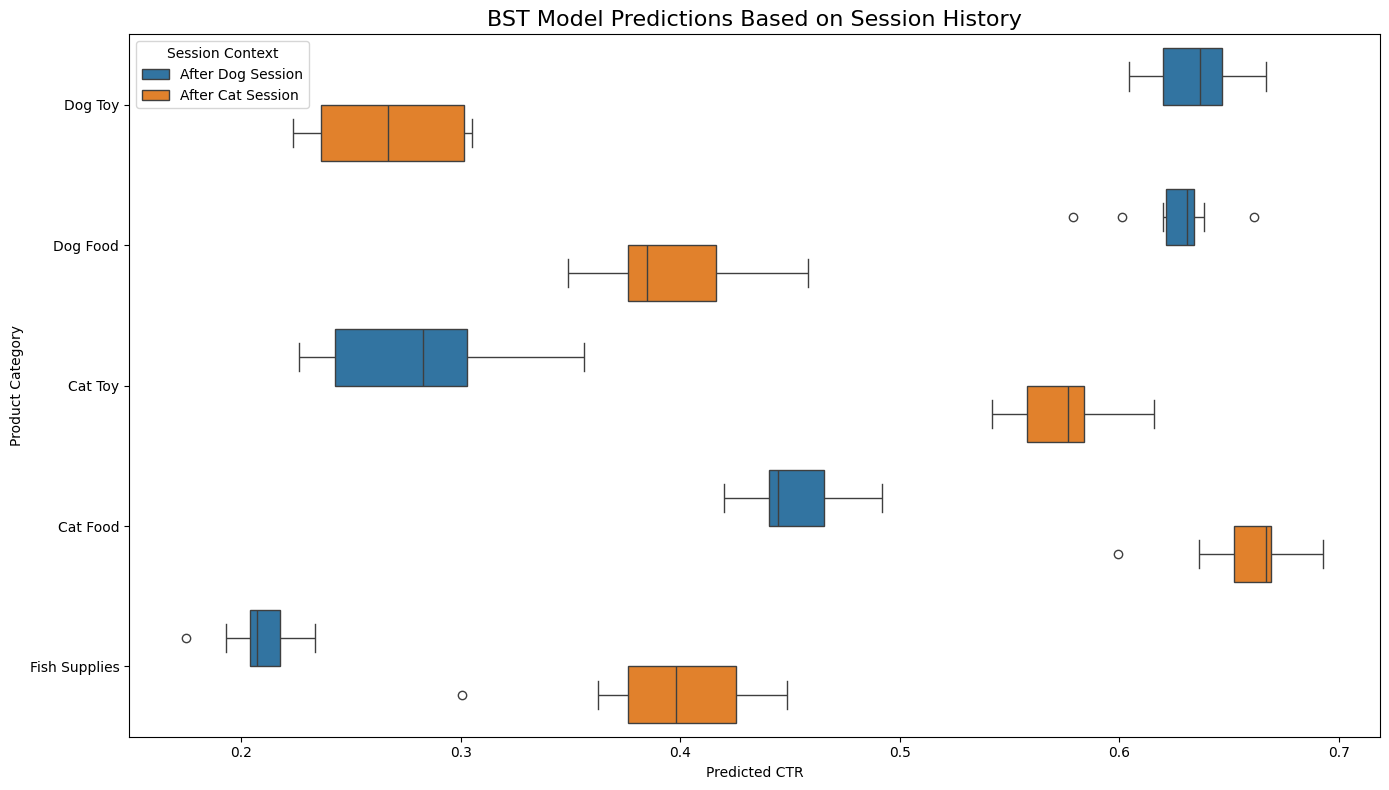

In [5]:
def get_bst_recommendations(model, history, n_products, device, max_len=10):
    """
    Gets the model's predicted CTR for all products given a history.
    """
    model.eval()
    
    # Pad the input history
    padded_history = np.pad(history, (max_len - len(history), 0), 'constant', constant_values=0)
    
    # Create tensors
    history_tensor = torch.tensor([padded_history] * n_products, dtype=torch.long).to(device)
    # Target items are all possible products from 1 to n_products
    target_items_tensor = torch.arange(1, n_products + 1, dtype=torch.long).to(device)

    with torch.no_grad():
        scores = model(history_tensor, target_items_tensor).squeeze().cpu().numpy()
        
    # Create a DataFrame for easy analysis
    results_df = pd.DataFrame({
        'product_id': np.arange(1, n_products + 1),
        'predicted_ctr': scores
    })
    results_df = results_df.join(sim.products, on='product_id')
    return results_df.sort_values('predicted_ctr', ascending=False)

# --- Test Case 1: Puppy Feeding Intent ---
# Let's find IDs for 'Dog Food' and 'Dog Toy'
dog_food_id = sim.products[sim.products['category'] == 'Dog Food'].index[0]
dog_toy_id = sim.products[sim.products['category'] == 'Dog Toy'].index[0]
puppy_history = [dog_food_id, dog_toy_id]

print("--- Test Case 1: 'Puppy' Intent ---")
print(f"Input History: [Dog Food (ID: {dog_food_id}), Dog Toy (ID: {dog_toy_id})]")
puppy_recs = get_bst_recommendations(bst_model, puppy_history, sim.n_products, device, MAX_SEQ_LEN)
print("Top 5 Recommendations:")
print(puppy_recs.head(5))


# --- Test Case 2: Cat Owner Intent ---
cat_food_id = sim.products[sim.products['category'] == 'Cat Food'].index[0]
cat_toy_id = sim.products[sim.products['category'] == 'Cat Toy'].index[0]
cat_history = [cat_food_id, cat_toy_id]

print("\n--- Test Case 2: 'Cat' Intent ---")
print(f"Input History: [Cat Food (ID: {cat_food_id}), Cat Toy (ID: {cat_toy_id})]")
cat_recs = get_bst_recommendations(bst_model, cat_history, sim.n_products, device, MAX_SEQ_LEN)
print("Top 5 Recommendations:")
print(cat_recs.head(5))


# --- Visualizing the difference ---
puppy_recs['source'] = 'After Dog Session'
cat_recs['source'] = 'After Cat Session'
plot_df = pd.concat([puppy_recs, cat_recs])

plt.figure(figsize=(14, 8))
sns.boxplot(data=plot_df, x='predicted_ctr', y='category', hue='source',
            order=['Dog Toy', 'Dog Food', 'Cat Toy', 'Cat Food', 'Fish Supplies'])
plt.title('BST Model Predictions Based on Session History', fontsize=16)
plt.xlabel('Predicted CTR')
plt.ylabel('Product Category')
plt.legend(title='Session Context')
plt.tight_layout()
plt.show()

#### **3.5 Discussion: When Sequence Matters Most**

The evaluation plot clearly demonstrates the power of the BST model. After a "Dog Session," the predicted CTRs for `Dog Toy` and `Dog Food` are dramatically higher than for other categories. Conversely, after a "Cat Session," the model correctly shifts its preferences to `Cat Toy` and `Cat Food`. It has successfully learned the short-term sequential patterns in user behavior. This is a capability that our previous models fundamentally lacked.

**Strengths of the Sequential Approach:**
*   **Captures Intent:** It models the user's current "mission," leading to more relevant and timely recommendations.
*   **Dynamic:** The recommendations change instantly as the user interacts with more items in the session.
*   **Solves Session Cold-Start:** It can provide meaningful recommendations even for anonymous users or users with no long-term history, as long as they have clicked on at least one item in the current session.

**Limitations and Considerations:**
*   **Data Requirements:** Sequential models require logs of *ordered* interactions. They perform best when sessions are well-defined and reasonably long.
*   **Computational Cost:** Transformers, while highly parallelizable, are more computationally intensive to train and serve than simpler models like the batched MLP or LinUCB.
*   **Ignoring Long-Term Preferences:** The pure BST model focuses heavily on the current session. A user's long-term profile (e.g., they are a `budget_shopper` who happens to be buying cat food today) is not explicitly modeled. Advanced architectures often combine sequential models with user embeddings (like those from Chapter 1) to get the best of both worlds.

In this chapter, we have added a crucial dimension to our understanding of personalization: the importance of sequence. By modeling the user's journey, we can move from generic predictions to understanding their immediate intent.

However, we are still missing one key source of information. So far, all our models have learned about users in isolation. But in a real-world e-commerce platform, users and items form a vast, interconnected network. The behavior of similar users can tell us a lot about what an individual might like. How can we tap into this "wisdom of the crowd"? This leads us to our next chapter, where we will explore the world of **Graph-Based Personalization**.